In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='5'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='mean_temp'
SAMPLE_SIZE=2000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_5_20250405_0011


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 63572/63572 [00:36<00:00, 1749.58it/s]


Saved 63572 profiles to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/20250405-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 63572it [00:03, 18434.64it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/density_plot.png


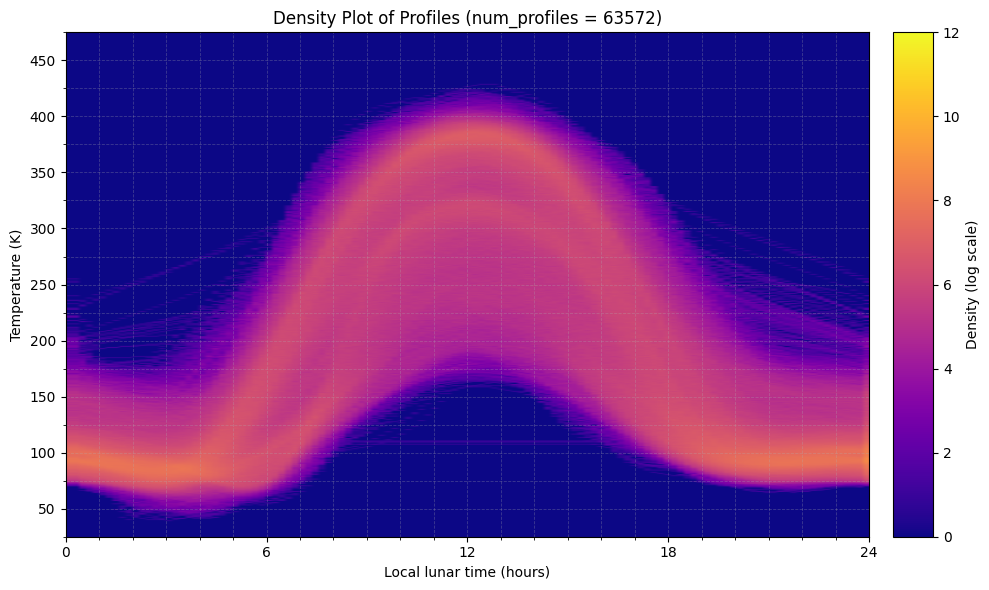

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/histogram_max_temp.png


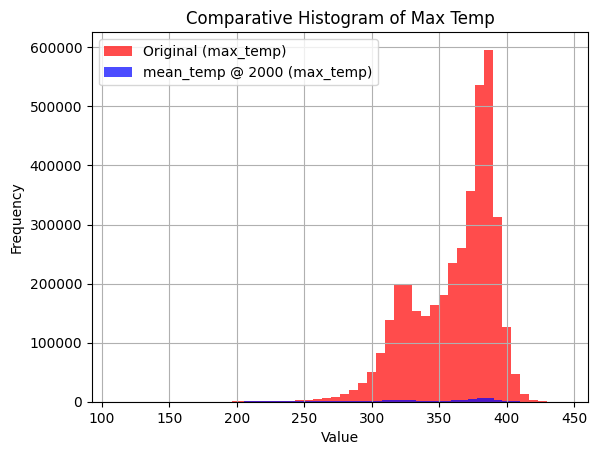

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/histogram_min_temp.png


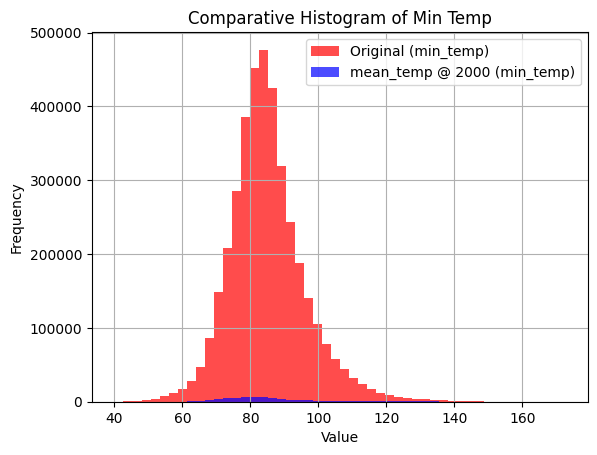

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/histogram_mean_temp.png


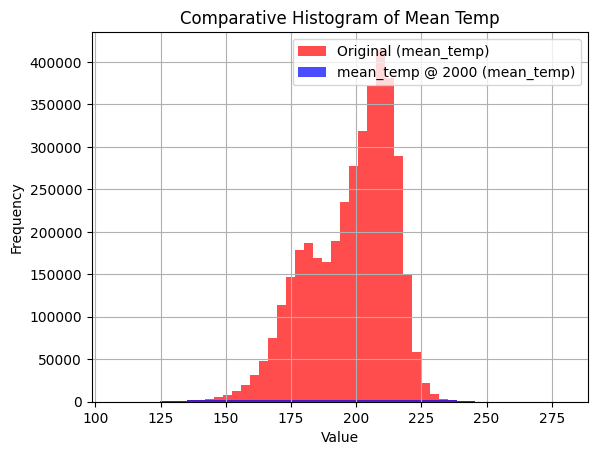

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250405_0011/histogram_std_temp.png


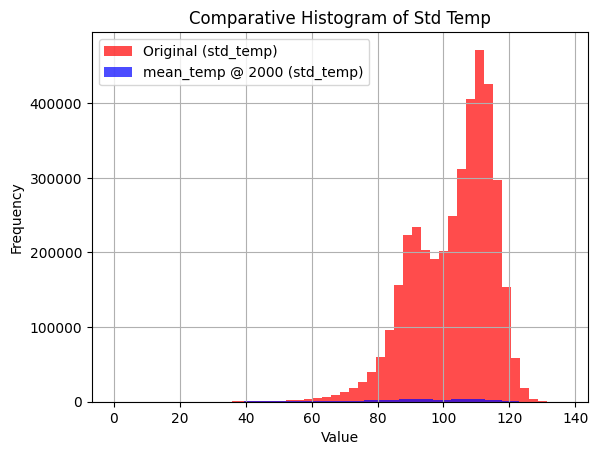

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 185.2930
STD: 96.9745
Min Temp: 40.0240
Max Temp: 428.7390
Datasets:
Training Data: 44500
Validation Data: 12714
Test Data: 6358


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 223/223 [00:06<00:00, 34.84it/s, best_loss=0.5875]


[Training] Epoch 1/100, L1 Loss: 0.6591, L2 Loss: 0.7060, KL Loss: 0.3144, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 64/64 [00:00<00:00, 131.20it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5102, Val KL Loss: 0.5168
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250405_0011'


[Training] Epoch 2/100: 100%|██████████| 223/223 [00:07<00:00, 31.72it/s, best_loss=0.5512]


[Training] Epoch 2/100, L1 Loss: 0.5730, L2 Loss: 0.5521, KL Loss: 0.4719, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 64/64 [00:00<00:00, 116.32it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4998, Val KL Loss: 0.5006
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250405_0011'


[Training] Epoch 3/100: 100%|██████████| 223/223 [00:07<00:00, 31.60it/s, best_loss=0.5601]


[Training] Epoch 3/100, L1 Loss: 0.5696, L2 Loss: 0.5470, KL Loss: 0.4747, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 64/64 [00:00<00:00, 104.76it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5017, Val KL Loss: 0.4826


[Training] Epoch 4/100: 100%|██████████| 223/223 [00:07<00:00, 29.68it/s, best_loss=0.5539]


[Training] Epoch 4/100, L1 Loss: 0.5689, L2 Loss: 0.5461, KL Loss: 0.4750, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 64/64 [00:00<00:00, 118.11it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5047, Val KL Loss: 0.4731


[Training] Epoch 5/100: 100%|██████████| 223/223 [00:07<00:00, 31.39it/s, best_loss=0.5200]


[Training] Epoch 5/100, L1 Loss: 0.5689, L2 Loss: 0.5459, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 64/64 [00:00<00:00, 116.10it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5045, Val KL Loss: 0.4725


[Training] Epoch 6/100: 100%|██████████| 223/223 [00:07<00:00, 31.54it/s, best_loss=0.5571]


[Training] Epoch 6/100, L1 Loss: 0.5687, L2 Loss: 0.5457, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 64/64 [00:00<00:00, 112.60it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5019, Val KL Loss: 0.4858


[Training] Epoch 7/100: 100%|██████████| 223/223 [00:07<00:00, 31.54it/s, best_loss=0.5601]


[Training] Epoch 7/100, L1 Loss: 0.5688, L2 Loss: 0.5462, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 64/64 [00:00<00:00, 107.87it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5034, Val KL Loss: 0.4759


[Training] Epoch 8/100: 100%|██████████| 223/223 [00:07<00:00, 31.57it/s, best_loss=0.5641]


[Training] Epoch 8/100, L1 Loss: 0.5688, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 64/64 [00:00<00:00, 111.90it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5030, Val KL Loss: 0.4795


[Training] Epoch 9/100: 100%|██████████| 223/223 [00:07<00:00, 29.71it/s, best_loss=0.5465]


[Training] Epoch 9/100, L1 Loss: 0.5694, L2 Loss: 0.5471, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 64/64 [00:00<00:00, 108.28it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5010, Val KL Loss: 0.4862


[Training] Epoch 10/100: 100%|██████████| 223/223 [00:07<00:00, 30.84it/s, best_loss=0.5485]


[Training] Epoch 10/100, L1 Loss: 0.5692, L2 Loss: 0.5468, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 64/64 [00:00<00:00, 109.27it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5054, Val KL Loss: 0.4691


[Training] Epoch 11/100: 100%|██████████| 223/223 [00:06<00:00, 34.31it/s, best_loss=0.5431]


[Training] Epoch 11/100, L1 Loss: 0.5688, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 64/64 [00:00<00:00, 125.27it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5048, Val KL Loss: 0.4715


[Training] Epoch 12/100: 100%|██████████| 223/223 [00:06<00:00, 32.26it/s, best_loss=0.5636]


[Training] Epoch 12/100, L1 Loss: 0.5689, L2 Loss: 0.5462, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 64/64 [00:00<00:00, 108.72it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5022, Val KL Loss: 0.4795


[Training] Epoch 13/100: 100%|██████████| 223/223 [00:06<00:00, 31.86it/s, best_loss=0.5554]


[Training] Epoch 13/100, L1 Loss: 0.5687, L2 Loss: 0.5458, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 64/64 [00:00<00:00, 65.47it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5039, Val KL Loss: 0.4721


[Training] Epoch 14/100: 100%|██████████| 223/223 [00:07<00:00, 31.17it/s, best_loss=0.5546]


[Training] Epoch 14/100, L1 Loss: 0.5688, L2 Loss: 0.5459, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 64/64 [00:00<00:00, 117.77it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5022, Val KL Loss: 0.4811


[Training] Epoch 15/100: 100%|██████████| 223/223 [00:06<00:00, 32.16it/s, best_loss=0.5649]


[Training] Epoch 15/100, L1 Loss: 0.5690, L2 Loss: 0.5459, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 64/64 [00:00<00:00, 109.00it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5048, Val KL Loss: 0.4705


[Training] Epoch 16/100: 100%|██████████| 223/223 [00:07<00:00, 31.17it/s, best_loss=0.5708]


[Training] Epoch 16/100, L1 Loss: 0.5691, L2 Loss: 0.5463, KL Loss: 0.4746, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 64/64 [00:00<00:00, 109.53it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5024, Val KL Loss: 0.4802


[Training] Epoch 17/100: 100%|██████████| 223/223 [00:06<00:00, 32.19it/s, best_loss=0.5546]


[Training] Epoch 17/100, L1 Loss: 0.5695, L2 Loss: 0.5467, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 64/64 [00:00<00:00, 109.19it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5007, Val KL Loss: 0.4841


[Training] Epoch 18/100: 100%|██████████| 223/223 [00:07<00:00, 30.81it/s, best_loss=0.5595]


[Training] Epoch 18/100, L1 Loss: 0.5693, L2 Loss: 0.5468, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 64/64 [00:00<00:00, 116.71it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5024, Val KL Loss: 0.4818


[Training] Epoch 19/100: 100%|██████████| 223/223 [00:07<00:00, 31.57it/s, best_loss=0.5533]


[Training] Epoch 19/100, L1 Loss: 0.5695, L2 Loss: 0.5466, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 64/64 [00:00<00:00, 110.02it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5050, Val KL Loss: 0.4621


[Training] Epoch 20/100: 100%|██████████| 223/223 [00:07<00:00, 31.18it/s, best_loss=0.5521]


[Training] Epoch 20/100, L1 Loss: 0.5696, L2 Loss: 0.5470, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 64/64 [00:00<00:00, 113.45it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5071, Val KL Loss: 0.4616


[Training] Epoch 21/100: 100%|██████████| 223/223 [00:06<00:00, 36.19it/s, best_loss=0.5560]


[Training] Epoch 21/100, L1 Loss: 0.5699, L2 Loss: 0.5474, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 64/64 [00:00<00:00, 136.30it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5033, Val KL Loss: 0.4797


[Training] Epoch 22/100: 100%|██████████| 223/223 [00:06<00:00, 34.60it/s, best_loss=0.5620]


[Training] Epoch 22/100, L1 Loss: 0.5691, L2 Loss: 0.5464, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 64/64 [00:00<00:00, 78.65it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5023, Val KL Loss: 0.4822


[Training] Epoch 23/100: 100%|██████████| 223/223 [00:06<00:00, 34.58it/s, best_loss=0.5431]


[Training] Epoch 23/100, L1 Loss: 0.5687, L2 Loss: 0.5457, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 64/64 [00:00<00:00, 130.85it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5033, Val KL Loss: 0.4804


[Training] Epoch 24/100: 100%|██████████| 223/223 [00:06<00:00, 32.82it/s, best_loss=0.5625]


[Training] Epoch 24/100, L1 Loss: 0.5692, L2 Loss: 0.5464, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 64/64 [00:00<00:00, 108.94it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5028, Val KL Loss: 0.4825


[Training] Epoch 25/100: 100%|██████████| 223/223 [00:07<00:00, 31.19it/s, best_loss=0.5611]


[Training] Epoch 25/100, L1 Loss: 0.5697, L2 Loss: 0.5471, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 64/64 [00:00<00:00, 116.24it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5289, Val L2 Loss: 0.5012, Val KL Loss: 0.4895


[Training] Epoch 26/100: 100%|██████████| 223/223 [00:07<00:00, 31.32it/s, best_loss=0.5577]


[Training] Epoch 26/100, L1 Loss: 0.5692, L2 Loss: 0.5463, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 64/64 [00:00<00:00, 109.86it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5047, Val KL Loss: 0.4756


[Training] Epoch 27/100: 100%|██████████| 223/223 [00:07<00:00, 29.61it/s, best_loss=0.5451]


[Training] Epoch 27/100, L1 Loss: 0.5694, L2 Loss: 0.5468, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 64/64 [00:00<00:00, 117.18it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5030, Val KL Loss: 0.4815


[Training] Epoch 28/100: 100%|██████████| 223/223 [00:06<00:00, 32.12it/s, best_loss=0.5584]


[Training] Epoch 28/100, L1 Loss: 0.5697, L2 Loss: 0.5473, KL Loss: 0.4747, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 64/64 [00:00<00:00, 126.11it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5032, Val KL Loss: 0.4744


[Training] Epoch 29/100: 100%|██████████| 223/223 [00:06<00:00, 32.35it/s, best_loss=0.5500]


[Training] Epoch 29/100, L1 Loss: 0.5687, L2 Loss: 0.5458, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 64/64 [00:00<00:00, 123.88it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5044, Val KL Loss: 0.4701


[Training] Epoch 30/100: 100%|██████████| 223/223 [00:06<00:00, 32.15it/s, best_loss=0.5471]


[Training] Epoch 30/100, L1 Loss: 0.5692, L2 Loss: 0.5464, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 64/64 [00:00<00:00, 109.23it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4998, Val KL Loss: 0.4994
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250405_0011'


[Training] Epoch 31/100: 100%|██████████| 223/223 [00:06<00:00, 32.35it/s, best_loss=0.5486]


[Training] Epoch 31/100, L1 Loss: 0.5696, L2 Loss: 0.5471, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 64/64 [00:00<00:00, 78.45it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5019, Val KL Loss: 0.4834


[Training] Epoch 32/100: 100%|██████████| 223/223 [00:07<00:00, 31.59it/s, best_loss=0.5646]


[Training] Epoch 32/100, L1 Loss: 0.5687, L2 Loss: 0.5457, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 64/64 [00:00<00:00, 111.62it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5032, Val KL Loss: 0.4763


[Training] Epoch 33/100: 100%|██████████| 223/223 [00:06<00:00, 33.36it/s, best_loss=0.5623]


[Training] Epoch 33/100, L1 Loss: 0.5691, L2 Loss: 0.5466, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 64/64 [00:00<00:00, 134.13it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5009, Val KL Loss: 0.4824


[Training] Epoch 34/100: 100%|██████████| 223/223 [00:06<00:00, 32.68it/s, best_loss=0.5606]


[Training] Epoch 34/100, L1 Loss: 0.5688, L2 Loss: 0.5459, KL Loss: 0.4751, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 64/64 [00:00<00:00, 124.22it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5006, Val KL Loss: 0.4906


[Training] Epoch 35/100: 100%|██████████| 223/223 [00:06<00:00, 34.22it/s, best_loss=0.5560]


[Training] Epoch 35/100, L1 Loss: 0.5688, L2 Loss: 0.5459, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 64/64 [00:00<00:00, 134.13it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5294, Val L2 Loss: 0.5017, Val KL Loss: 0.4868


[Training] Epoch 36/100: 100%|██████████| 223/223 [00:06<00:00, 32.20it/s, best_loss=0.5633]


[Training] Epoch 36/100, L1 Loss: 0.5684, L2 Loss: 0.5455, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 64/64 [00:00<00:00, 109.72it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5042, Val KL Loss: 0.4732


[Training] Epoch 37/100: 100%|██████████| 223/223 [00:07<00:00, 31.37it/s, best_loss=0.5312]


[Training] Epoch 37/100, L1 Loss: 0.5694, L2 Loss: 0.5469, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 64/64 [00:00<00:00, 116.45it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5016, Val KL Loss: 0.4900


[Training] Epoch 38/100: 100%|██████████| 223/223 [00:07<00:00, 31.21it/s, best_loss=0.5564]


[Training] Epoch 38/100, L1 Loss: 0.5695, L2 Loss: 0.5467, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 64/64 [00:00<00:00, 106.03it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5033, Val KL Loss: 0.4783


[Training] Epoch 39/100: 100%|██████████| 223/223 [00:07<00:00, 31.76it/s, best_loss=0.5668]


[Training] Epoch 39/100, L1 Loss: 0.5696, L2 Loss: 0.5471, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 64/64 [00:00<00:00, 108.78it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5022, Val KL Loss: 0.4827


[Training] Epoch 40/100: 100%|██████████| 223/223 [00:06<00:00, 32.69it/s, best_loss=0.5656]


[Training] Epoch 40/100, L1 Loss: 0.5688, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 64/64 [00:00<00:00, 106.53it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5023, Val KL Loss: 0.4838


[Training] Epoch 41/100: 100%|██████████| 223/223 [00:07<00:00, 30.56it/s, best_loss=0.5622]


[Training] Epoch 41/100, L1 Loss: 0.5691, L2 Loss: 0.5459, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 64/64 [00:00<00:00, 126.92it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.4997, Val KL Loss: 0.4973
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250405_0011'


[Training] Epoch 42/100: 100%|██████████| 223/223 [00:06<00:00, 32.30it/s, best_loss=0.5562]


[Training] Epoch 42/100, L1 Loss: 0.5686, L2 Loss: 0.5456, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 64/64 [00:00<00:00, 125.52it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5336, Val L2 Loss: 0.5055, Val KL Loss: 0.4671


[Training] Epoch 43/100: 100%|██████████| 223/223 [00:06<00:00, 32.13it/s, best_loss=0.5659]


[Training] Epoch 43/100, L1 Loss: 0.5687, L2 Loss: 0.5458, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 64/64 [00:00<00:00, 117.33it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5062, Val KL Loss: 0.4672


[Training] Epoch 44/100: 100%|██████████| 223/223 [00:07<00:00, 31.37it/s, best_loss=0.5558]


[Training] Epoch 44/100, L1 Loss: 0.5688, L2 Loss: 0.5460, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 64/64 [00:00<00:00, 114.90it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5019, Val KL Loss: 0.4851


[Training] Epoch 45/100: 100%|██████████| 223/223 [00:06<00:00, 32.66it/s, best_loss=0.5382]


[Training] Epoch 45/100, L1 Loss: 0.5699, L2 Loss: 0.5477, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 64/64 [00:00<00:00, 132.42it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5042, Val KL Loss: 0.4734


[Training] Epoch 46/100: 100%|██████████| 223/223 [00:06<00:00, 35.84it/s, best_loss=0.5631]


[Training] Epoch 46/100, L1 Loss: 0.5692, L2 Loss: 0.5463, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 64/64 [00:00<00:00, 138.61it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5050, Val KL Loss: 0.4710


[Training] Epoch 47/100: 100%|██████████| 223/223 [00:06<00:00, 34.03it/s, best_loss=0.5595]


[Training] Epoch 47/100, L1 Loss: 0.5696, L2 Loss: 0.5469, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 64/64 [00:00<00:00, 118.54it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5008, Val KL Loss: 0.4916


[Training] Epoch 48/100: 100%|██████████| 223/223 [00:06<00:00, 32.31it/s, best_loss=0.5545]


[Training] Epoch 48/100, L1 Loss: 0.5690, L2 Loss: 0.5462, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 64/64 [00:00<00:00, 124.55it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5018, Val KL Loss: 0.4845


[Training] Epoch 49/100: 100%|██████████| 223/223 [00:06<00:00, 32.12it/s, best_loss=0.5239]


[Training] Epoch 49/100, L1 Loss: 0.5691, L2 Loss: 0.5462, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 64/64 [00:00<00:00, 112.67it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5033, Val KL Loss: 0.4811


[Training] Epoch 50/100: 100%|██████████| 223/223 [00:07<00:00, 29.11it/s, best_loss=0.5672]


[Training] Epoch 50/100, L1 Loss: 0.5690, L2 Loss: 0.5458, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 64/64 [00:00<00:00, 112.12it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5024, Val KL Loss: 0.4792


[Training] Epoch 51/100: 100%|██████████| 223/223 [00:06<00:00, 31.91it/s, best_loss=0.5484]


[Training] Epoch 51/100, L1 Loss: 0.5693, L2 Loss: 0.5465, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 64/64 [00:00<00:00, 109.43it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5353, Val L2 Loss: 0.5070, Val KL Loss: 0.4681


[Training] Epoch 52/100: 100%|██████████| 223/223 [00:07<00:00, 30.42it/s, best_loss=0.5590]


[Training] Epoch 52/100, L1 Loss: 0.5690, L2 Loss: 0.5464, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 64/64 [00:00<00:00, 109.20it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5019, Val KL Loss: 0.4861


[Training] Epoch 53/100: 100%|██████████| 223/223 [00:07<00:00, 31.62it/s, best_loss=0.5598]


[Training] Epoch 53/100, L1 Loss: 0.5688, L2 Loss: 0.5460, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 64/64 [00:00<00:00, 113.15it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5046, Val KL Loss: 0.4712


[Training] Epoch 54/100: 100%|██████████| 223/223 [00:07<00:00, 29.65it/s, best_loss=0.5580]


[Training] Epoch 54/100, L1 Loss: 0.5687, L2 Loss: 0.5458, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 64/64 [00:00<00:00, 108.83it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5023, Val KL Loss: 0.4817


[Training] Epoch 55/100: 100%|██████████| 223/223 [00:07<00:00, 30.90it/s, best_loss=0.5519]


[Training] Epoch 55/100, L1 Loss: 0.5691, L2 Loss: 0.5463, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 64/64 [00:00<00:00, 124.12it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5017, Val KL Loss: 0.4814


[Training] Epoch 56/100: 100%|██████████| 223/223 [00:07<00:00, 31.68it/s, best_loss=0.5539]


[Training] Epoch 56/100, L1 Loss: 0.5695, L2 Loss: 0.5469, KL Loss: 0.4747, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 64/64 [00:00<00:00, 119.35it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5024, Val KL Loss: 0.4787


[Training] Epoch 57/100: 100%|██████████| 223/223 [00:06<00:00, 34.48it/s, best_loss=0.5449]


[Training] Epoch 57/100, L1 Loss: 0.5693, L2 Loss: 0.5466, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 64/64 [00:00<00:00, 133.73it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5030, Val KL Loss: 0.4745


[Training] Epoch 58/100: 100%|██████████| 223/223 [00:06<00:00, 33.61it/s, best_loss=0.5387]


[Training] Epoch 58/100, L1 Loss: 0.5691, L2 Loss: 0.5464, KL Loss: 0.4747, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 64/64 [00:00<00:00, 134.66it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5017, Val KL Loss: 0.4832


[Training] Epoch 59/100: 100%|██████████| 223/223 [00:06<00:00, 32.35it/s, best_loss=0.5644]


[Training] Epoch 59/100, L1 Loss: 0.5692, L2 Loss: 0.5464, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 64/64 [00:00<00:00, 139.67it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5032, Val KL Loss: 0.4768


[Training] Epoch 60/100: 100%|██████████| 223/223 [00:06<00:00, 35.16it/s, best_loss=0.5580]


[Training] Epoch 60/100, L1 Loss: 0.5693, L2 Loss: 0.5467, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 64/64 [00:00<00:00, 141.31it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5352, Val L2 Loss: 0.5068, Val KL Loss: 0.4672


[Training] Epoch 61/100: 100%|██████████| 223/223 [00:06<00:00, 34.36it/s, best_loss=0.5655]


[Training] Epoch 61/100, L1 Loss: 0.5689, L2 Loss: 0.5461, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 64/64 [00:00<00:00, 119.49it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5054, Val KL Loss: 0.4688


[Training] Epoch 62/100: 100%|██████████| 223/223 [00:06<00:00, 32.84it/s, best_loss=0.5689]


[Training] Epoch 62/100, L1 Loss: 0.5691, L2 Loss: 0.5467, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 64/64 [00:00<00:00, 122.82it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5030, Val KL Loss: 0.4795


[Training] Epoch 63/100: 100%|██████████| 223/223 [00:07<00:00, 30.51it/s, best_loss=0.5558]


[Training] Epoch 63/100, L1 Loss: 0.5690, L2 Loss: 0.5464, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 64/64 [00:00<00:00, 115.28it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4998, Val KL Loss: 0.4953


[Training] Epoch 64/100: 100%|██████████| 223/223 [00:06<00:00, 31.94it/s, best_loss=0.5481]


[Training] Epoch 64/100, L1 Loss: 0.5691, L2 Loss: 0.5465, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 64/64 [00:00<00:00, 124.71it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5033, Val KL Loss: 0.4804


[Training] Epoch 65/100: 100%|██████████| 223/223 [00:06<00:00, 33.46it/s, best_loss=0.5518]


[Training] Epoch 65/100, L1 Loss: 0.5693, L2 Loss: 0.5464, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 64/64 [00:00<00:00, 122.84it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5038, Val KL Loss: 0.4761


[Training] Epoch 66/100: 100%|██████████| 223/223 [00:06<00:00, 33.28it/s, best_loss=0.5438]


[Training] Epoch 66/100, L1 Loss: 0.5688, L2 Loss: 0.5461, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 64/64 [00:00<00:00, 120.76it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5035, Val KL Loss: 0.4728


[Training] Epoch 67/100: 100%|██████████| 223/223 [00:06<00:00, 33.51it/s, best_loss=0.5539]


[Training] Epoch 67/100, L1 Loss: 0.5691, L2 Loss: 0.5462, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 64/64 [00:00<00:00, 129.13it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5035, Val KL Loss: 0.4791


[Training] Epoch 68/100: 100%|██████████| 223/223 [00:06<00:00, 32.23it/s, best_loss=0.5519]


[Training] Epoch 68/100, L1 Loss: 0.5683, L2 Loss: 0.5458, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 64/64 [00:00<00:00, 118.96it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5050, Val KL Loss: 0.4745


[Training] Epoch 69/100: 100%|██████████| 223/223 [00:06<00:00, 32.63it/s, best_loss=0.5543]


[Training] Epoch 69/100, L1 Loss: 0.5694, L2 Loss: 0.5467, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 64/64 [00:00<00:00, 112.87it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5031, Val KL Loss: 0.4790


[Training] Epoch 70/100: 100%|██████████| 223/223 [00:06<00:00, 32.60it/s, best_loss=0.5633]


[Training] Epoch 70/100, L1 Loss: 0.5697, L2 Loss: 0.5475, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 64/64 [00:00<00:00, 120.43it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5053, Val KL Loss: 0.4737


[Training] Epoch 71/100: 100%|██████████| 223/223 [00:06<00:00, 33.62it/s, best_loss=0.5549]


[Training] Epoch 71/100, L1 Loss: 0.5687, L2 Loss: 0.5458, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 64/64 [00:00<00:00, 130.42it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5035, Val KL Loss: 0.4793


[Training] Epoch 72/100: 100%|██████████| 223/223 [00:06<00:00, 33.42it/s, best_loss=0.5594]


[Training] Epoch 72/100, L1 Loss: 0.5694, L2 Loss: 0.5460, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 64/64 [00:00<00:00, 79.06it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5027, Val KL Loss: 0.4838


[Training] Epoch 73/100: 100%|██████████| 223/223 [00:06<00:00, 33.35it/s, best_loss=0.5363]


[Training] Epoch 73/100, L1 Loss: 0.5689, L2 Loss: 0.5459, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 64/64 [00:00<00:00, 125.11it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5047, Val KL Loss: 0.4749


[Training] Epoch 74/100: 100%|██████████| 223/223 [00:06<00:00, 34.15it/s, best_loss=0.5684]


[Training] Epoch 74/100, L1 Loss: 0.5691, L2 Loss: 0.5466, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 64/64 [00:00<00:00, 117.62it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5058, Val KL Loss: 0.4650


[Training] Epoch 75/100: 100%|██████████| 223/223 [00:06<00:00, 32.51it/s, best_loss=0.5647]


[Training] Epoch 75/100, L1 Loss: 0.5694, L2 Loss: 0.5466, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 64/64 [00:00<00:00, 120.10it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5045, Val KL Loss: 0.4702


[Training] Epoch 76/100: 100%|██████████| 223/223 [00:06<00:00, 32.59it/s, best_loss=0.5460]


[Training] Epoch 76/100, L1 Loss: 0.5691, L2 Loss: 0.5462, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 64/64 [00:00<00:00, 111.80it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5005, Val KL Loss: 0.4837


[Training] Epoch 77/100: 100%|██████████| 223/223 [00:07<00:00, 30.05it/s, best_loss=0.5514]


[Training] Epoch 77/100, L1 Loss: 0.5691, L2 Loss: 0.5467, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 64/64 [00:00<00:00, 123.55it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5016, Val KL Loss: 0.4856


[Training] Epoch 78/100: 100%|██████████| 223/223 [00:06<00:00, 32.80it/s, best_loss=0.5335]


[Training] Epoch 78/100, L1 Loss: 0.5686, L2 Loss: 0.5460, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 64/64 [00:00<00:00, 109.13it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4999, Val KL Loss: 0.4977


[Training] Epoch 79/100: 100%|██████████| 223/223 [00:07<00:00, 31.61it/s, best_loss=0.5518]


[Training] Epoch 79/100, L1 Loss: 0.5692, L2 Loss: 0.5465, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 64/64 [00:00<00:00, 114.70it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5022, Val KL Loss: 0.4813


[Training] Epoch 80/100: 100%|██████████| 223/223 [00:06<00:00, 32.20it/s, best_loss=0.5592]


[Training] Epoch 80/100, L1 Loss: 0.5689, L2 Loss: 0.5459, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 64/64 [00:00<00:00, 104.62it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5028, Val KL Loss: 0.4826


[Training] Epoch 81/100: 100%|██████████| 223/223 [00:06<00:00, 31.95it/s, best_loss=0.5675]


[Training] Epoch 81/100, L1 Loss: 0.5694, L2 Loss: 0.5470, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 64/64 [00:00<00:00, 76.19it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5051, Val KL Loss: 0.4655


[Training] Epoch 82/100: 100%|██████████| 223/223 [00:06<00:00, 33.68it/s, best_loss=0.5626]


[Training] Epoch 82/100, L1 Loss: 0.5694, L2 Loss: 0.5467, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 64/64 [00:00<00:00, 123.62it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5042, Val KL Loss: 0.4744


[Training] Epoch 83/100: 100%|██████████| 223/223 [00:06<00:00, 34.14it/s, best_loss=0.5532]


[Training] Epoch 83/100, L1 Loss: 0.5686, L2 Loss: 0.5457, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 64/64 [00:00<00:00, 122.17it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5045, Val KL Loss: 0.4765


[Training] Epoch 84/100: 100%|██████████| 223/223 [00:06<00:00, 32.73it/s, best_loss=0.5591]


[Training] Epoch 84/100, L1 Loss: 0.5687, L2 Loss: 0.5457, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 64/64 [00:00<00:00, 119.37it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5024, Val KL Loss: 0.4866


[Training] Epoch 85/100: 100%|██████████| 223/223 [00:06<00:00, 33.38it/s, best_loss=0.5585]


[Training] Epoch 85/100, L1 Loss: 0.5684, L2 Loss: 0.5452, KL Loss: 0.4750, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 64/64 [00:00<00:00, 109.35it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5014, Val KL Loss: 0.4895


[Training] Epoch 86/100: 100%|██████████| 223/223 [00:07<00:00, 31.85it/s, best_loss=0.5627]


[Training] Epoch 86/100, L1 Loss: 0.5688, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 64/64 [00:00<00:00, 118.65it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5006, Val KL Loss: 0.4885


[Training] Epoch 87/100: 100%|██████████| 223/223 [00:06<00:00, 33.68it/s, best_loss=0.5620]


[Training] Epoch 87/100, L1 Loss: 0.5692, L2 Loss: 0.5465, KL Loss: 0.4747, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 64/64 [00:00<00:00, 116.90it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5032, Val KL Loss: 0.4817


[Training] Epoch 88/100: 100%|██████████| 223/223 [00:07<00:00, 31.76it/s, best_loss=0.5450]


[Training] Epoch 88/100, L1 Loss: 0.5691, L2 Loss: 0.5467, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 64/64 [00:00<00:00, 125.26it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5054, Val KL Loss: 0.4710


[Training] Epoch 89/100: 100%|██████████| 223/223 [00:06<00:00, 32.18it/s, best_loss=0.5549]


[Training] Epoch 89/100, L1 Loss: 0.5694, L2 Loss: 0.5466, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 64/64 [00:00<00:00, 113.88it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5032, Val KL Loss: 0.4771


[Training] Epoch 90/100: 100%|██████████| 223/223 [00:06<00:00, 32.72it/s, best_loss=0.5527]


[Training] Epoch 90/100, L1 Loss: 0.5687, L2 Loss: 0.5460, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 64/64 [00:00<00:00, 109.55it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5013, Val KL Loss: 0.4858


[Training] Epoch 91/100: 100%|██████████| 223/223 [00:07<00:00, 30.06it/s, best_loss=0.5607]


[Training] Epoch 91/100, L1 Loss: 0.5693, L2 Loss: 0.5463, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 64/64 [00:00<00:00, 114.22it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5036, Val KL Loss: 0.4770


[Training] Epoch 92/100: 100%|██████████| 223/223 [00:06<00:00, 34.24it/s, best_loss=0.5608]


[Training] Epoch 92/100, L1 Loss: 0.5693, L2 Loss: 0.5468, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 64/64 [00:00<00:00, 127.94it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5010, Val KL Loss: 0.4860


[Training] Epoch 93/100: 100%|██████████| 223/223 [00:06<00:00, 34.16it/s, best_loss=0.5586]


[Training] Epoch 93/100, L1 Loss: 0.5692, L2 Loss: 0.5467, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 64/64 [00:00<00:00, 122.68it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4999, Val KL Loss: 0.4950


[Training] Epoch 94/100: 100%|██████████| 223/223 [00:06<00:00, 32.77it/s, best_loss=0.5596]


[Training] Epoch 94/100, L1 Loss: 0.5695, L2 Loss: 0.5469, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 64/64 [00:00<00:00, 109.65it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.4999, Val KL Loss: 0.4900


[Training] Epoch 95/100: 100%|██████████| 223/223 [00:07<00:00, 30.80it/s, best_loss=0.5622]


[Training] Epoch 95/100, L1 Loss: 0.5705, L2 Loss: 0.5482, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 64/64 [00:00<00:00, 130.58it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5027, Val KL Loss: 0.4779


[Training] Epoch 96/100: 100%|██████████| 223/223 [00:06<00:00, 32.94it/s, best_loss=0.5486]


[Training] Epoch 96/100, L1 Loss: 0.5689, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 64/64 [00:00<00:00, 115.31it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5046, Val KL Loss: 0.4764


[Training] Epoch 97/100: 100%|██████████| 223/223 [00:06<00:00, 33.24it/s, best_loss=0.5539]


[Training] Epoch 97/100, L1 Loss: 0.5692, L2 Loss: 0.5467, KL Loss: 0.4748, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 64/64 [00:00<00:00, 124.08it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5011, Val KL Loss: 0.4884


[Training] Epoch 98/100: 100%|██████████| 223/223 [00:06<00:00, 33.45it/s, best_loss=0.5526]


[Training] Epoch 98/100, L1 Loss: 0.5696, L2 Loss: 0.5470, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 64/64 [00:00<00:00, 128.71it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5054, Val KL Loss: 0.4729


[Training] Epoch 99/100: 100%|██████████| 223/223 [00:06<00:00, 32.87it/s, best_loss=0.5512]


[Training] Epoch 99/100, L1 Loss: 0.5690, L2 Loss: 0.5461, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 64/64 [00:00<00:00, 112.56it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5026, Val KL Loss: 0.4760


[Training] Epoch 100/100: 100%|██████████| 223/223 [00:06<00:00, 33.56it/s, best_loss=0.5399]


[Training] Epoch 100/100, L1 Loss: 0.5689, L2 Loss: 0.5463, KL Loss: 0.4749, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 64/64 [00:00<00:00, 113.15it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5052, Val KL Loss: 0.4736


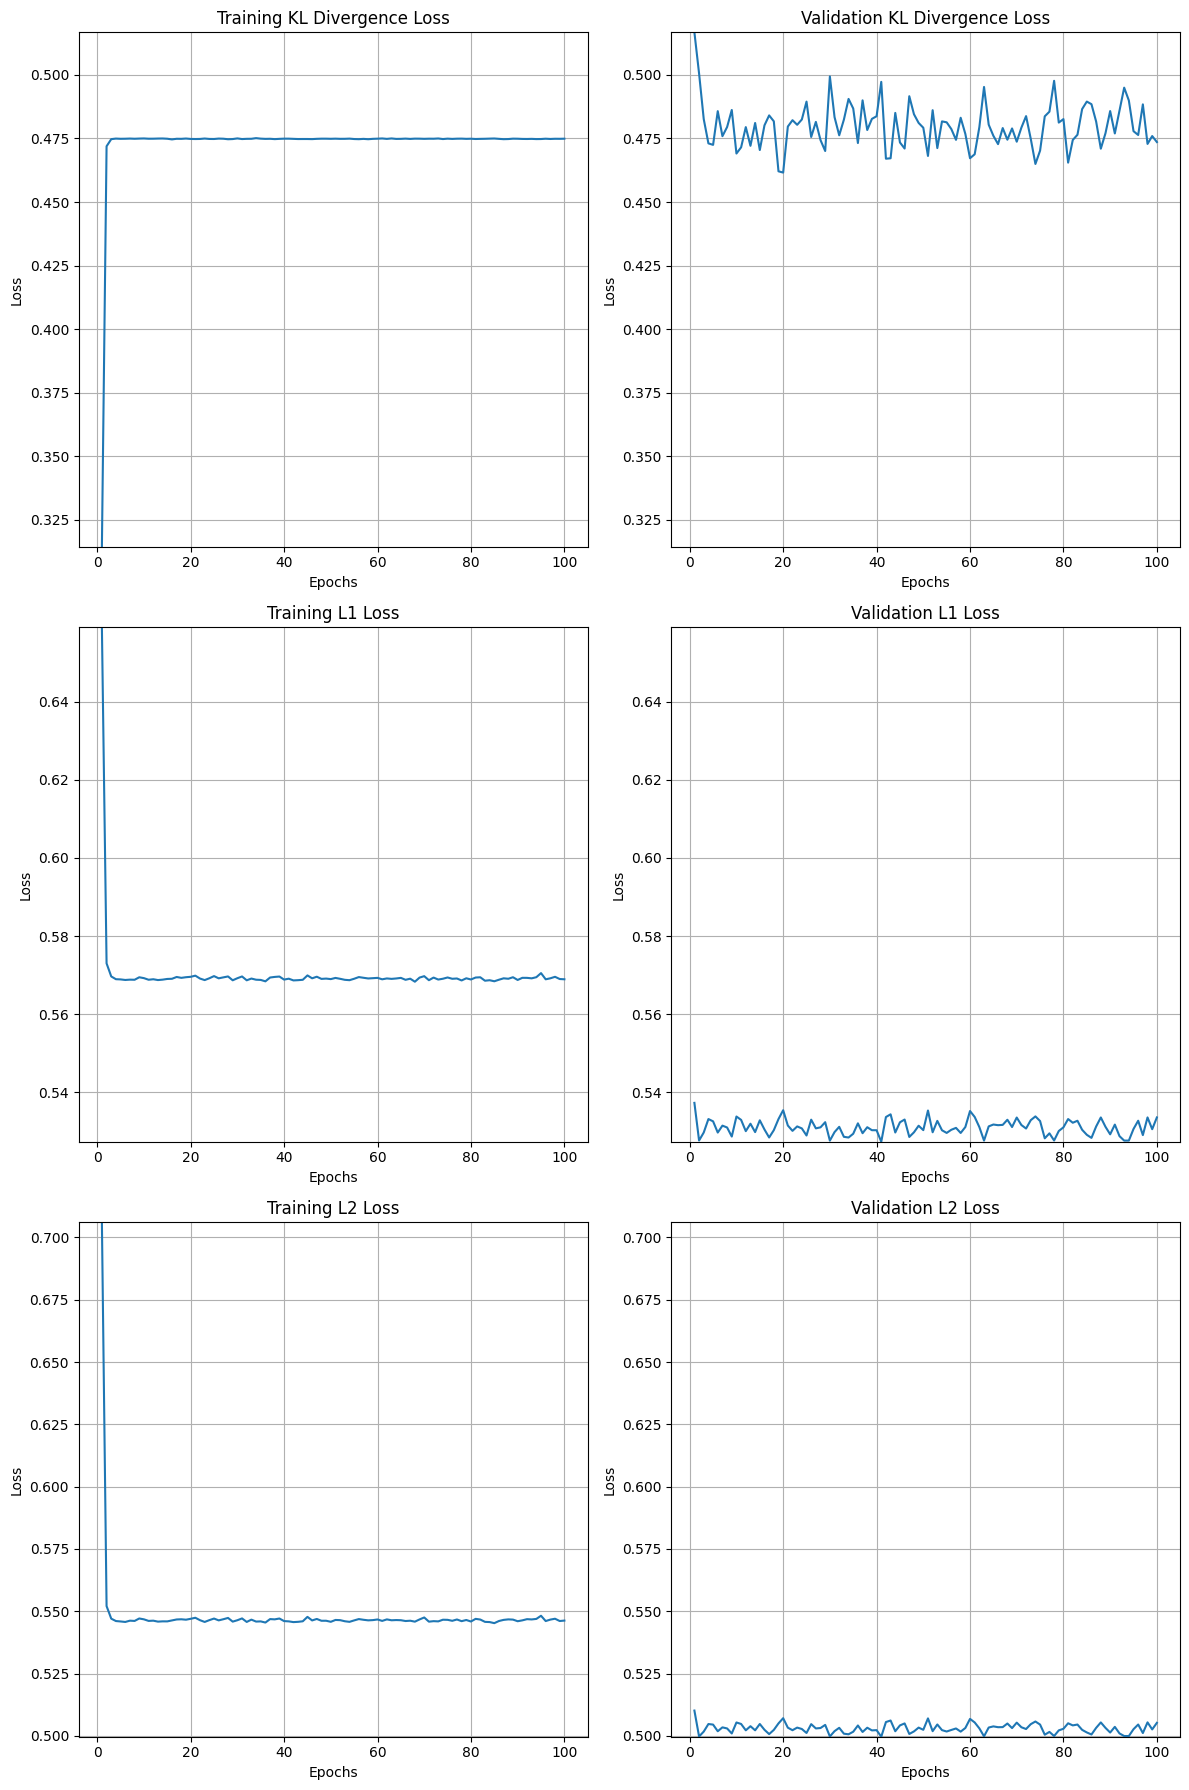

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
51.1355 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


z0: 0.0137
z1: -0.0134
z2: -0.0022
z3: -0.1034


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 743.93it/s]


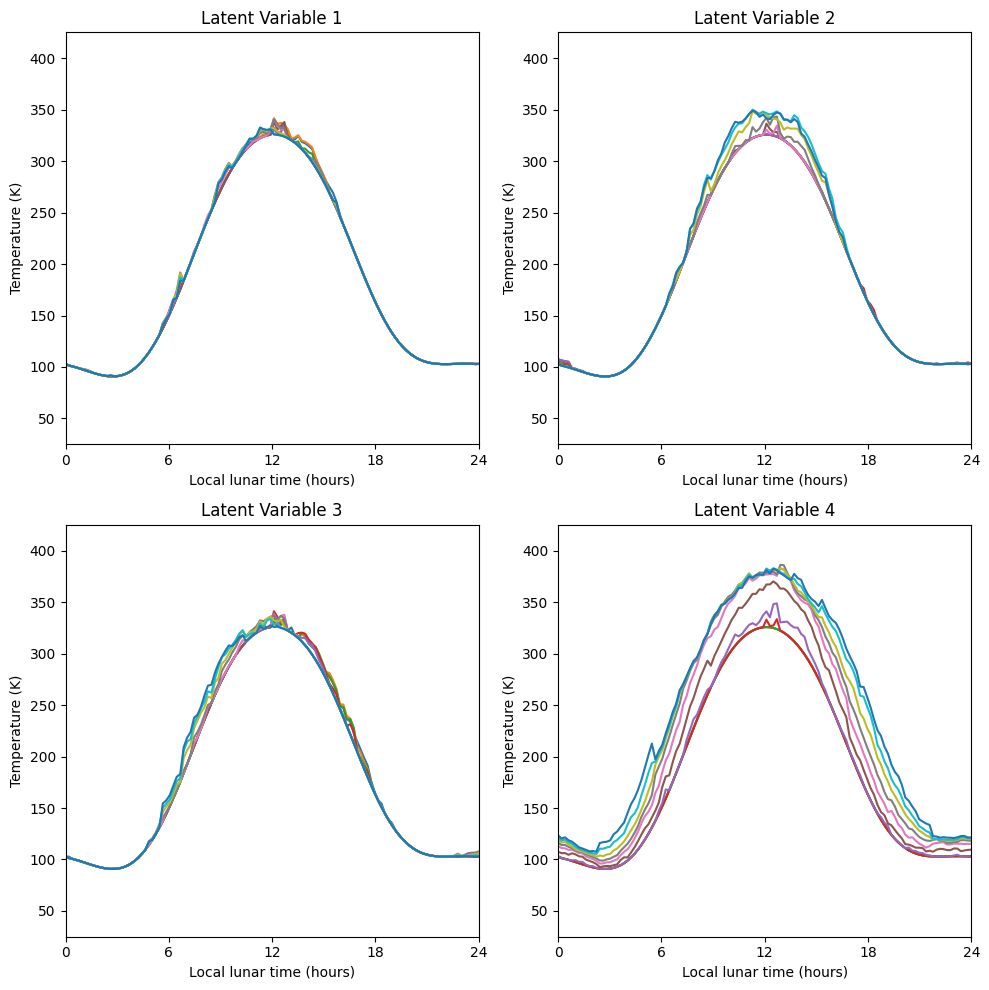

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)